In [1]:
from __future__ import division

In [2]:
import numpy as np

In [3]:
import healpy as hp
from healpy import query_disc, query_polygon

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
import opsimsummary as oss

In [6]:
import pandas as pd

In [7]:
from sqlalchemy import create_engine

In [8]:
import time

In [9]:
from scipy import sparse

In [10]:
begin = time.time()

dbname = '/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db'
engine = create_engine('sqlite:///' + dbname)
DD = 54
WFD = 56
OpSim_combined = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID in ({0}, {1})'.format(DD, WFD) , engine, 
                                   index_col='obsHistID')
OpSim_combined.reset_index(inplace=True)
OpSim_combined = OpSim_combined.drop_duplicates('obsHistID')
assert len(OpSim_combined) == OpSim_combined.obsHistID.unique().size
OpSim_combined.set_index('obsHistID', inplace=True)')
OpSim_combined.to_hdf('/Users/rbiswas/data/LSST/OpSimData/minion_1016.hdf', 'Table')

In [11]:
raCol = 'ditheredRA'
decCol = 'ditheredDec'

This is the relevant part of the OpSim output converted into hdf format

In [12]:
OpSim_combined = pd.read_hdf('/Users/rbiswas/data/LSST/OpSimData/minion_1016.hdf', 'Table')

In [13]:
# Check that only the DDF and WFD fields are included
assert OpSim_combined.propID.unique().all() == np.array([54, 56]).all()

In [14]:
OpSim_combined.reset_index(inplace=True)

In [15]:
# Check that there are no duplicates
assert OpSim_combined.obsHistID.unique().size == OpSim_combined.obsHistID.size

In [16]:
def addCartesian(df, raCol='ditheredRA', decCol='ditheredDec'):
    #theta = - df[decCol] + np.pi/2.
    Z = np.sin(df[decCol])    
    X = np.cos(df[decCol]) * np.sin(df[raCol])
    Y = np.cos(df[decCol]) * np.cos(df[raCol])
    df['X'] = X
    df['Y'] = Y
    df['Z'] = Z

In [17]:
def addVec(df, raCol='ditheredRA', decCol='ditheredDec'):
    thetas  = - df[decCol] + np.pi /2.
    phis = df[raCol]
    df['vec'] = list(hp.ang2vec(thetas, phis))

In [18]:
tstart = time.time()
addVec(OpSim_combined, raCol=raCol, decCol=decCol)
tend = time.time()
print(tend - tstart)

1.76136302948


In [19]:
NSIDE = 256

In [20]:
tstart = time.time()
OpSim_combined['hids'] = [query_disc(NSIDE, vec, np.radians(1.75), inclusive=True) for vec in OpSim_combined.vec]
tend = time.time()
print(tend - tstart)

97.1378660202


In [21]:
lens = map(len, OpSim_combined.hids.values)

In [22]:
from itertools import repeat

In [23]:
tstart = time.time()
rowdata = []
#xx = [[ind] * lens[i] for ind, i in enumerate(lens)]
_ = list(rowdata.extend(repeat(i, lens[i])) for i in xrange(len(OpSim_combined)))
tend  = time.time()
print(tend - tstart)

6.15033197403


In [24]:
tstart = time.time()
coldata = np.concatenate(OpSim_combined.hids.values)
tend  = time.time()
print(tend - tstart)

6.85123300552


In [25]:
_aa = np.shape(coldata) 
_bb = np.shape(rowdata)
assert _aa == _bb

In [26]:
shape=(len(OpSim_combined), hp.nside2npix(256))

In [27]:
tstart = time.time()
spmat = sparse.csr_matrix((np.ones(len(rowdata)), (np.asarray(rowdata), coldata)), shape=shape)
tend = time.time()
print(tend - tstart)

81.832752943


In [28]:
tstart = time.time()
obs = spmat.sum(axis=0)
tend = time.time()
print(tend - tstart)

3.91236281395


In [37]:
obs = np.asarray(obs).reshape(len(obs.transpose())) #, np.shape(obs)[1]

In [38]:
end  = time.time()

In [39]:
hpobs = np.where(obs > 2000., 2000., obs)
hpobs = np.where(hpobs < 1000., hp.UNSEEN, hpobs)

In [40]:
print(end - begin)

344.087437868


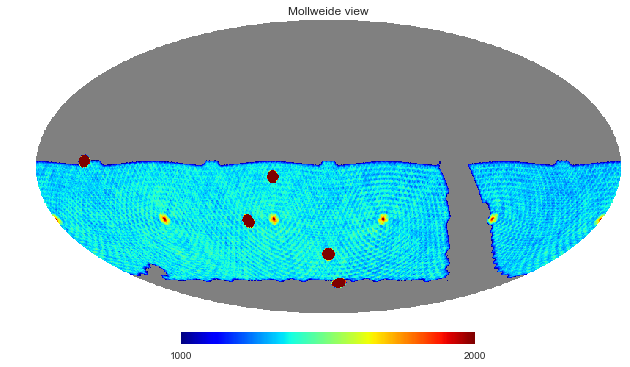

In [41]:
hp.mollview(hpobs)

### What is newrowdata ?

In [42]:
tstart = time.time()
newrowdata = np.bincount(coldata)
tend = time.time()
print(tend - tstart)

1.8097550869


In [43]:
hidvals = set()
for row in OpSim_combined.hids.values:
    hidvals.update(set(row))

In [44]:

print('len of newrowdata, len of rowdata, number of pixels, number of pixels used = ', len(newrowdata), len(rowdata), hp.nside2npix(NSIDE),
     len(hidvals))
assert all(newrowdata == obs[:len(newrowdata)])

('len of newrowdata, len of rowdata, number of pixels, number of pixels used = ', 754419, 484970963, 786432, 370840)


In [60]:
xx = spmat.transpose()

In [66]:
np.asarray(xx[0].todense()).size

2194905

In [74]:
hvals = np.asarray(list(hidvals))

In [79]:
OpSim_combined.columns

Index([        u'obsHistID',         u'sessionID',            u'propID',
                 u'fieldID',           u'fieldRA',          u'fieldDec',
                  u'filter',           u'expDate',            u'expMJD',
                   u'night',         u'visitTime',      u'visitExpTime',
                 u'finRank',           u'FWHMeff',          u'FWHMgeom',
            u'transparency',           u'airmass',        u'vSkyBright',
       u'filtSkyBrightness',         u'rotSkyPos',         u'rotTelPos',
                     u'lst',          u'altitude',           u'azimuth',
               u'dist2Moon',        u'solarElong',            u'moonRA',
                 u'moonDec',           u'moonAlt',            u'moonAZ',
               u'moonPhase',            u'sunAlt',             u'sunAz',
              u'phaseAngle',          u'rScatter',        u'mieScatter',
               u'moonIllum',        u'moonBright',        u'darkBright',
               u'rawSeeing',              u'wind', 

In [93]:
tstart = time.time()
xy = list(OpSim_combined.ix[xx[hval].nonzero()[1], 'expMJD'].diff().max() for hval in hvals[:100])
tend = time.time()
print(tend - tstart)

85.6667079926


In [94]:
tstart = time.time()
xy = list(OpSim_combined.ix[xx[hval].nonzero()[1], 'fiveSigmaDepth'].max() for hval in hvals[:100])
tend = time.time()
print(tend - tstart)

91.2221758366


In [96]:
tstart = time.time()
xy = list(xx[hval].nonzero()[1] for hval in hvals[:100])
tend = time.time()
print(tend - tstart)

83.3932440281


In [ ]:
# These are slow because getting the nonzero values from csr matrix is too slow (at least in the way I tried it). 


# Scratch

In [ ]:
tstart = time.time()
xxx = OpSim_combined.ix[rowdata, 'obsHistID']
tend = time.time()
print(tend - tstart)

In [ ]:
xxx

In [ ]:
df = pd.DataFrame(dict(obsHistID=OpSim_combined.ix[rowdata].obsHistID,
                 healIds=coldata))

# Scratch

In [ ]:
shape

In [ ]:
x.shape[0]

In [ ]:
obs = x.sum(axis=1).reshape(x.shape[0])

In [ ]:
hp.mollview(obs)

In [ ]:
hp.mollview(map=)

In [ ]:
plt.hist(x)

In [ ]:
from itertools import repeat

In [ ]:
newdata = [elem for subl in xx for elem in subl]

In [ ]:
newdata == datarows

In [ ]:
len(OpSim_combined)

In [ ]:
xx = datarows

In [ ]:
len(newdata)

In [ ]:
len(datarows)

In [ ]:
tend - tstart

In [ ]:
OpSim_combined.reset_index(inplace=True)

In [ ]:
shape[0] * shape[1]

In [ ]:
OpSim_combined.index.max()# - len(OpSim_combined)

In [ ]:
OpSim_combined[OpSim_combined.expMJD.diff() < 0]

In [ ]:
OpSim_combined['hids']

In [ ]:
OpSim_combined['hidsFull'] = [query_disc(64, vec, np.radians(1.75), inclusive=False) for vec in OpSim_combined.vec]

In [ ]:
OpSim_combined.expMJD.min()

In [ ]:
len(OpSim_combined.query('expMJD  < {0} + 170 and expMJD > {0}'.format(59580. + 365. * 4.0)).query('fieldID == 309'))

In [ ]:
set(OpSim_combined.hids.values[0]) - set(OpSim_combined.hidsFull.values[0])

In [ ]:
inside = len(set(OpSim_combined.hids.values[0]).intersection(set(OpSim_combined.hidsFull.values[0])))

In [ ]:
OpSim_combined.hidsFull.values[0]

In [ ]:
hidvals = set()
for row in OpSim_combined.hids.values:
    hidvals.update(set(row))

In [ ]:
len(hidvals) / hp.nside2npix(256)

In [ ]:
hidvals = np.asarray(list(hidvals))

In [ ]:
len(hidvals) / 20. * 9.0 /60. / 60.

In [ ]:
fields = [OpSim_combined[OpSim_combined['hids'].apply(lambda x: hid in x)].fieldID for hid in hidvals[:100]]

In [ ]:
Twinkleshidvals = set()
for row in OpSim_combined.query('fieldID == 1427').hids.values:
    Twinkleshidvals.update(set(row))

In [ ]:
Twinkleshidvals  = np.asarray(list(Twinkleshidvals))

In [ ]:
len(Twinkleshidvals)

In [ ]:
len(Twinkleshidvals)

In [ ]:
%timeit _ = OpSim_combined[OpSim_combined.hids.apply(lambda x: 36006 in x)]

In [ ]:
np.pi * np.radians(1.75)**2./hp.nside2pixarea(64)

In [ ]:
Twinklesfields = [OpSim_combined[OpSim_combined.hids.apply(lambda x: hid in x)]for hid in Twinkleshidvals]

In [ ]:
mapVal = np.ones(hp.nside2npix(64)) * hp.UNSEEN

In [ ]:
mapVal[Twinkleshidvals] = 1.

In [ ]:
fig ax

In [ ]:
phi, theta = np.degrees(OpSim_combined.query('fieldID == 1427')[['fieldRA', 'fieldDec']].values[0])

In [ ]:
theta=-theta + 90.

In [ ]:
hp.dir2vec()

In [ ]:
import matplotlib

In [ ]:
hp.mollzoom(mapVal, rot=(phi, theta, 0))

In [ ]:
hp.mollview(mapVal)

In [ ]:
OpSim_combined.query('fieldID == 1427').fieldID.size

In [ ]:
plt.hist(map(len, Twinklesfields), histtype='step', lw=2., alpha=1.)
plt.axvline(24175)

In [ ]:
OpSim_combined.query('fieldID == 1427')['hids'].apply(lambda x: hid in x).fieldID# for hid in Twinkleshidvals]

In [ ]:
Twinklesfields = [OpSim_combined.query('fieldID == 1427')[OpSim_combined.query('fieldID == 1427')['hids'].apply(lambda x: hid in x)].fieldID for hid in Twinkleshidvals

In [ ]:
Twinklesfields

In [ ]:
plt.stem(map(len, fields))

In [ ]:
fields[0]

In [ ]:
fields[20]

In [ ]:
np.array(map(lambda x: len(x.unique()), fields)) > 1

In [ ]:
plt.plot(map(lambda x: len(x.unique()), fields), map(len, fields), 'o')

In [ ]:
map(lenfields[40:50]

In [ ]:
plt.plot(map(lambda x: len(x.unique()), fields), map(len, fields), 'o')

In [ ]:
hp.pix2ang(64, hidvals[:100])

In [ ]:
OpSim_combined.['vec'].apply(hp.query_disc(), args=(np.radians(1.75), ))a


In [ ]:
x[0]

In [ ]:
np.shape(x)

In [ ]:
xx = [query_disc(256, vec, np.radians(1.75), inclusive=True) for vec in OpSim_combined.vec]

In [ ]:
OpSim_combined['hids'] = [query_disc(256, vec, np.radians(1.75), inclusive=True) for vec in OpSim_combined.vec]

In [ ]:
len(OpSim_combined)

In [ ]:
hidvals = np.unique(np.asarray([OpSim_combined.hids.values]))

In [ ]:
mylist = []
for hids in xx:
    for elem in hids
       mylist.append(elem)

In [ ]:
%%timeit  
hidvals = np.unique(np.array([elem for hids in xx for elem in hids]))

In [ ]:
np.vstack(np.array([np.array([1., 2.]), np.array([2., 3.])]))

In [ ]:
xx = OpSim_combined.hids.values[0:10].copy()

In [ ]:
hidvals = np.unique(np.asarray([xx for xx in OpSim_combined.hids.values]))

In [ ]:
%%timeit
hidvals = OpSim_combined.hids.values)

In [ ]:
OpSim_combined[OpSim_combined.hids.apply(lambda x: 743074 in x)].fieldID.unique()

In [ ]:
OpSim_combined.ix[1, 'hids']

In [ ]:
%%timeit 
hids = query_disc(256, OpSim_combined['vec'], np.radians(1.75), inclusive=True)


In [ ]:
import healpy as hp

In [ ]:
np.pi * np.radians(1.75)**2.

In [ ]:
np.radians(np.sqrt(9.6))**2.

In [ ]:
hp.nside2pixarea(256)

In [ ]:
hp.ang2vec(np.pi/2., np.pi)

In [ ]:
hids

In [ ]:
OpSim_combined['hids'] = [query_disc(64, (OpSim_combined.ix[ind, 'X'],OpSim_combined.ix[ind, 'Y'], OpSim_combined.ix[ind, 'Z']), np.radians(1.75), 
                  inclusive=True) for ind in OpSim_combined.index]

In [ ]:
OpSim_combined.ix[1, 'hids']

In [ ]:
OpSim_combined['hids'] = [np.random.randint(1, 500, 16) for x in range(len(OpSim_combined))]

In [ ]:
def contains(x, y):
    return x in y

In [ ]:
def overlaps(hid, df):
    x = df.hids.apply(hid in)
    return df[x]

In [ ]:
from __future__ import division

In [ ]:
%timeit len(OpSim_combined[OpSim_combined.hids.apply(lambda x: 348 in x)])

In [ ]:
fraction = []
ss = len(OpSim_combined)
for i in range(1, 501):
    fraction.append(len(OpSim_combined[OpSim_combined.hids.apply(lambda x: i in x)]))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
np.asarray(fraction) /ss  - 16./ 500.

In [ ]:
plt.hist(np.array(fraction)/ss)

In [ ]:
len(OpSim_combined)

In [ ]:
overlaps(348, OpSim_combined)

In [ ]:
contains(348, OpSim_combined.hids)

In [ ]:
OpSim_combined.query('316 == fieldID')

In [ ]:
for lst in OpSim_combined['hids']:
    

In [ ]:
def get_overlappObs(OpSim_combined, hid):
    OpSim_combined['overlap'] = hid in 